# Code for Exercise 2. {-}

For this problem, I am using the dynamic programming template created by Jason DeBacker.

First let's import the relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here, we set our parameters equal to those specified in the problem:

In [2]:
gamma = 0.5 # CRRA coefficient
beta = 0.96 # discount factor
delta = 0.05 # depreciation rate
alpha = 0.4 # curvature of production function
sigma_z = 0.2 # SD of productivity shocks

We now set up our state space grid:

In [3]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = .5
ub_k = 10
size_k = 200  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

Next, we run a Monte Carlo simulation with $\mathtt{numtrials=500}$ trials, each time setting matrices $C, Y, $ and $I$ to zeroes, and $Z$ to an empty list. Each iteration, we re-populate $Z$ with $\mathcal{N}\left(0,\sigma_z ^2 \right)$-distributed random variables, and then populate the $C, Y, I$ matrices with their relevant calculations, based off the $\mathtt{k}\_\mathtt{grid}$ values. Next, we take the sample average over all the Monte Carlo simulations, define some regularity conditions, and set the CRRA utility function based off the consumption we found.

In [4]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption
I        = matrix, current investment
Z        = matrix, productivity shocks
U        = matrix, current period utility value for all possible
           choices of k and k' (rows are k, columns k')
numtrials= number of trials in Monte Carlo sim
allCs    = list of all the C's for numtrials different trials with different shocks
allIs    = analogous to allCs but for the I's
------------------------------------------------------------------------
'''
allCs = []
allIs = []
numtrials = 500
for n in range(numtrials):
    C = np.zeros((size_k, size_k)) 
    Y = np.zeros((size_k, size_k))
    I = np.zeros((size_k, size_k))
    Z = []
    for i in range(size_k):
        Z.append(np.exp(np.random.normal(0,sigma_z))) # productivity shocks, iid normal with sigma_z SD
    Z=np.array(Z)
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            Y[i,j] = Z[i] * k_grid[i] ** alpha # production function = stoch shock * capital ^ alpha
            I[i,j] = k_grid[j] - (1-delta) * k_grid[i] # investment, determined by the k'=(1-delta)k+i law of motion
            C[i, j] = Y[i,j] - I[i,j] # resource constraint
    allCs.append(C)
    allIs.append(I)

C = np.zeros((size_k,size_k))
I = np.zeros((size_k,size_k))
for i in range(size_k):
        for j in range(size_k):
            avgCs = 0
            avgIs = 0
            for n in range(numtrials):
                avgCs += allCs[n][i,j]
                avgIs += allIs[n][i,j]
            avgCs /= numtrials
            avgIs /= numtrials
            C[i,j] = avgCs
            I[i,j] = avgIs

# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
I[I<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1-gamma)) / (1-gamma)
U[C<0] = -1e10

Now, this next step is virtually the same as we covered in class, where I apply a Bellman equation $V_{T+1} = u(c) + \beta \cdot V_{T}$ looped over multiple iterations, recalculation the value function many times and corresponding policy functions.

In [5]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 5.0 
VFmaxiter = 3000 
V = np.zeros(size_k) # initial guess at value function
Vmat = np.zeros((size_k, size_k)) # initialize Vmat matrix
Vstore = np.zeros((size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            Vmat[i, j] = U[i, j] + beta * V[j] 
      
    Vstore[:, VFiter] = V.reshape(size_k,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 484


There were $\mathtt{484}$ iterations.

This next part involves using the formula for the choice of consumption based off capital, organized in the order of the $\mathtt{PF}$-selected values. I used the formula
$$
\mathtt{optC} = \mathtt{Z}_{\mathtt{PF}} \cdot \mathtt{k}\_\mathtt{grid} ^ \mathtt{alpha} - \left( \mathtt{optK} - (1-\mathtt{delta}) \cdot \mathtt{k}\_\mathtt{grid} \right),
$$
i.e.,
$$
c=z\cdot k^\alpha - (k^{\prime} - (1-\delta)\cdot k).
$$

In [6]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c' for each c
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal capital size (savings function)
optC = Z[PF] * k_grid ** alpha - (optK - (1-delta) * k_grid) # optimal consumption, get consumption through the transition eqn

Plotting the $\bf{value}$ $\bf{function}$, we have:

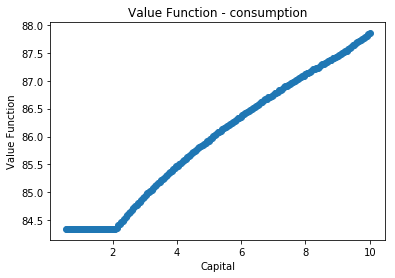

In [7]:
# Plot value function 
plt.figure()
# plt.plot(wvec, VF)
plt.scatter(k_grid[1:], VF[1:])
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function - consumption')
plt.show()

Now we plot the $\bf{policy}$ $\bf{function}$ for the choice of consumption:

<Figure size 432x288 with 0 Axes>

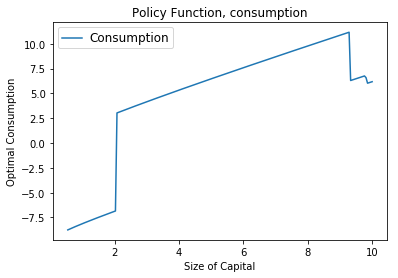

In [8]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption')
plt.show()

Finally, we plot the $\bf{policy}$ $\bf{function}$ for the choice of capital next period:

<Figure size 432x288 with 0 Axes>

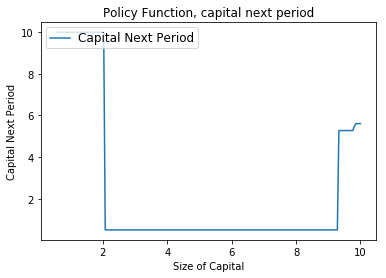

In [9]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:], label='Capital Next Period')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Capital Next Period')
plt.title('Policy Function, capital next period')
plt.show()